In [ ]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

In [ ]:
# !pip install fastai --upgrade

In [ ]:
# from fastai.data.external import untar_data, URLs
# coco_path = untar_data(URLs.COCO_SAMPLE)
# coco_path = str(coco_path) + "/train_sample"
# use_colab = True

In [ ]:
!unzip -q '/content/drive/MyDrive/BE_project/Dataset1.zip'

replace Dataset/data/image_0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
if use_colab == True:
    path = coco_path
else:
    path = "/content/Dataset/data"
    
paths = glob.glob(path + "/*.png") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 4_000, replace=False) 
rand_idxs = np.random.permutation(4_000)
train_idxs = rand_idxs[:3500] 
val_idxs = rand_idxs[500:] 
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

3500 3500


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


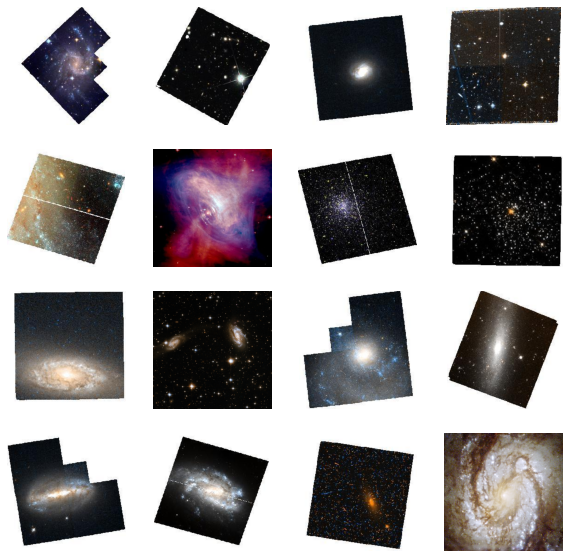

In [ ]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [ ]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [ ]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
219 219


In [ ]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [ ]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [ ]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [ ]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

# model = MainModel()
# train_model(model, train_dl, 100)

In [ ]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [ ]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [ ]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0))
            
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()        
pretrain_generator(net_G, train_dl, opt, criterion, 30)
torch.save(net_G.state_dict(), "pytorch_resnet-18.pt")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch 1/30
L1 Loss: 0.03057



Epoch 2/30
L1 Loss: 0.02388



Epoch 3/30
L1 Loss: 0.02307



Epoch 4/30
L1 Loss: 0.02258



Epoch 5/30
L1 Loss: 0.02233



Epoch 6/30
L1 Loss: 0.02207



Epoch 7/30
L1 Loss: 0.02199



Epoch 8/30
L1 Loss: 0.02181



Epoch 9/30
L1 Loss: 0.02168



Epoch 10/30
L1 Loss: 0.02161



Epoch 11/30
L1 Loss: 0.02147



Epoch 12/30
L1 Loss: 0.02133



Epoch 13/30
L1 Loss: 0.02127



Epoch 14/30
L1 Loss: 0.02111



Epoch 15/30
L1 Loss: 0.02099



Epoch 16/30
L1 Loss: 0.02085



Epoch 17/30
L1 Loss: 0.02063



Epoch 18/30
L1 Loss: 0.02055



Epoch 19/30
L1 Loss: 0.02031



Epoch 20/30
L1 Loss: 0.02020



Epoch 21/30
L1 Loss: 0.02004



Epoch 22/30
L1 Loss: 0.01993



Epoch 23/30
L1 Loss: 0.01958



Epoch 24/30
L1 Loss: 0.01964



Epoch 25/30
L1 Loss: 0.01909



Epoch 26/30
L1 Loss: 0.01898



Epoch 27/30
L1 Loss: 0.01861



Epoch 28/30
L1 Loss: 0.01853



Epoch 29/30
L1 Loss: 0.01832



Epoch 30/30
L1 Loss: 0.01790


model initialized with norm initialization


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch 1/20
Iteration 200/219
loss_D_fake: 0.62765
loss_D_real: 0.64503
loss_D: 0.63634
loss_G_GAN: 0.97306
loss_G_L1: 2.47311
loss_G: 3.44617


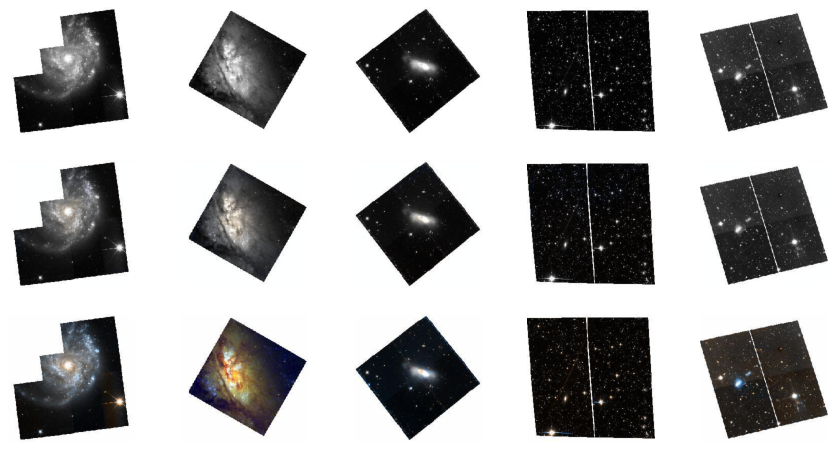


Epoch 2/20
Iteration 200/219
loss_D_fake: 0.63817
loss_D_real: 0.65023
loss_D: 0.64420
loss_G_GAN: 0.94688
loss_G_L1: 2.54266
loss_G: 3.48954


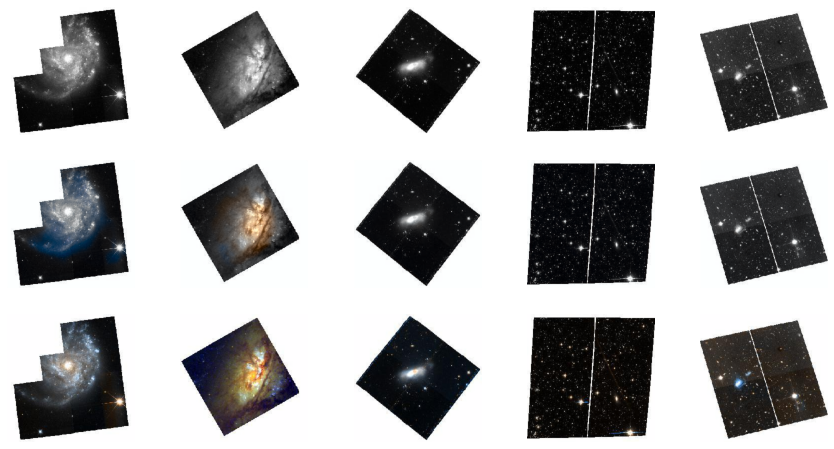


Epoch 3/20
Iteration 200/219
loss_D_fake: 0.63216
loss_D_real: 0.63806
loss_D: 0.63511
loss_G_GAN: 1.00031
loss_G_L1: 2.62743
loss_G: 3.62774


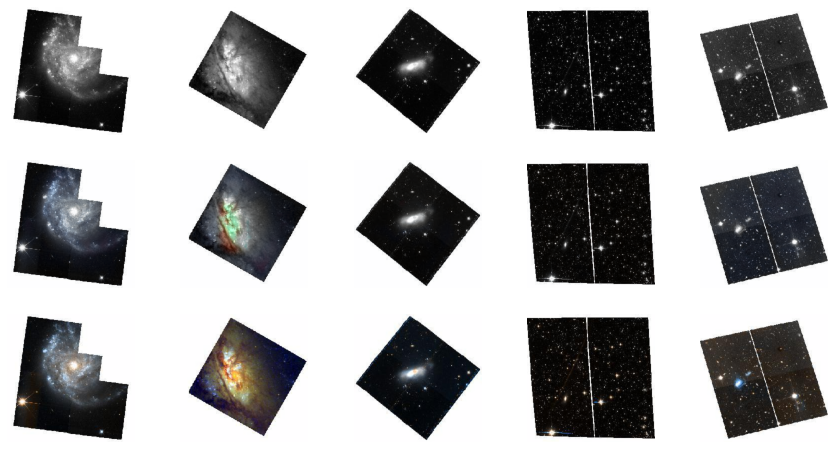


Epoch 4/20
Iteration 200/219
loss_D_fake: 0.66815
loss_D_real: 0.68203
loss_D: 0.67509
loss_G_GAN: 0.85160
loss_G_L1: 2.50740
loss_G: 3.35901


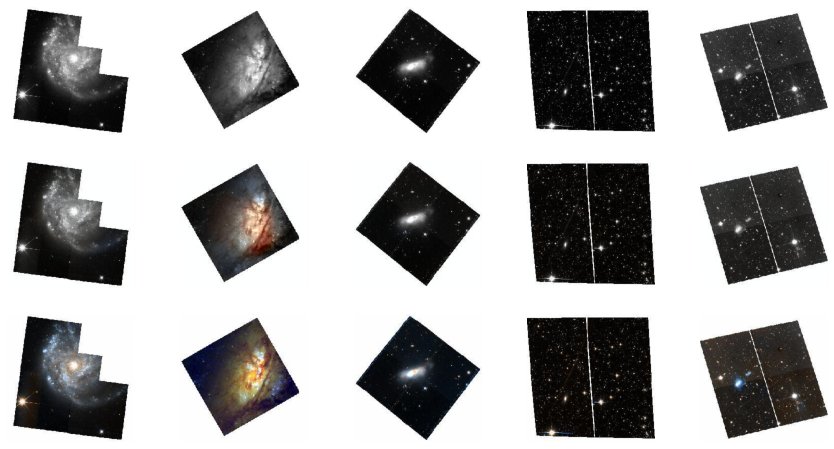


Epoch 5/20
Iteration 200/219
loss_D_fake: 0.66328
loss_D_real: 0.67002
loss_D: 0.66665
loss_G_GAN: 0.85340
loss_G_L1: 2.48959
loss_G: 3.34299


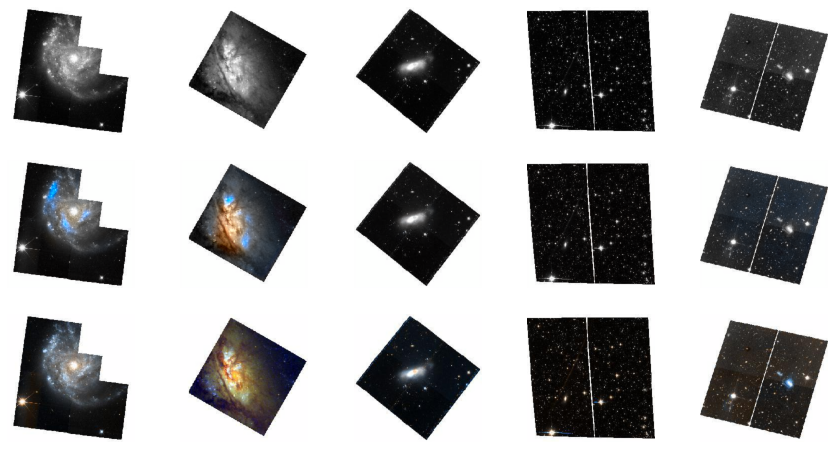


Epoch 6/20
Iteration 200/219
loss_D_fake: 0.67200
loss_D_real: 0.68122
loss_D: 0.67661
loss_G_GAN: 0.80941
loss_G_L1: 2.34500
loss_G: 3.15441


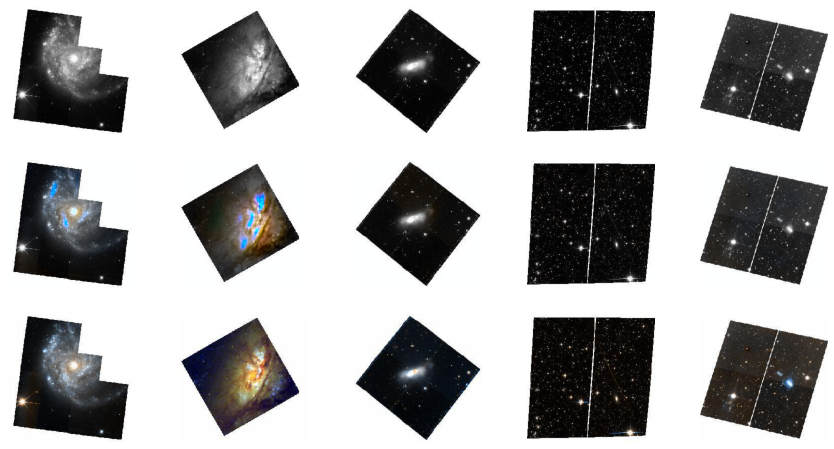


Epoch 7/20
Iteration 200/219
loss_D_fake: 0.66442
loss_D_real: 0.67347
loss_D: 0.66894
loss_G_GAN: 0.81336
loss_G_L1: 2.28810
loss_G: 3.10146


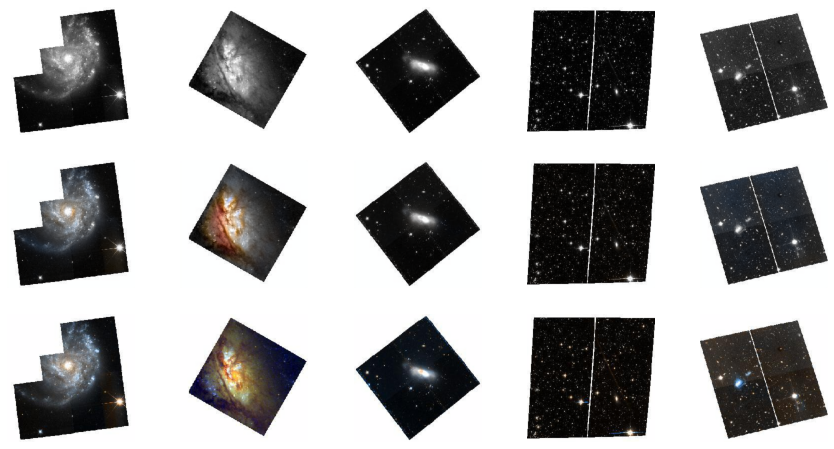


Epoch 8/20
Iteration 200/219
loss_D_fake: 0.66985
loss_D_real: 0.67422
loss_D: 0.67203
loss_G_GAN: 0.81291
loss_G_L1: 2.23285
loss_G: 3.04576


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 11 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 67 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


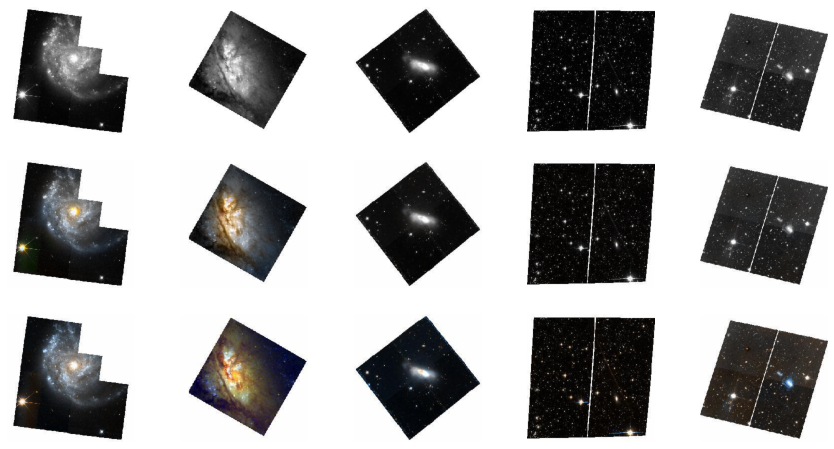


Epoch 9/20
Iteration 200/219
loss_D_fake: 0.66803
loss_D_real: 0.67387
loss_D: 0.67095
loss_G_GAN: 0.81775
loss_G_L1: 2.17441
loss_G: 2.99217


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 17 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


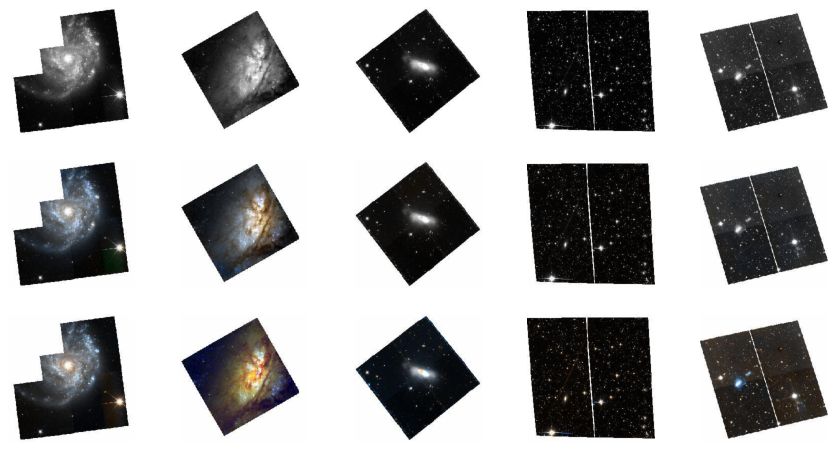


Epoch 10/20
Iteration 200/219
loss_D_fake: 0.66893
loss_D_real: 0.67222
loss_D: 0.67058
loss_G_GAN: 0.80987
loss_G_L1: 2.14494
loss_G: 2.95481


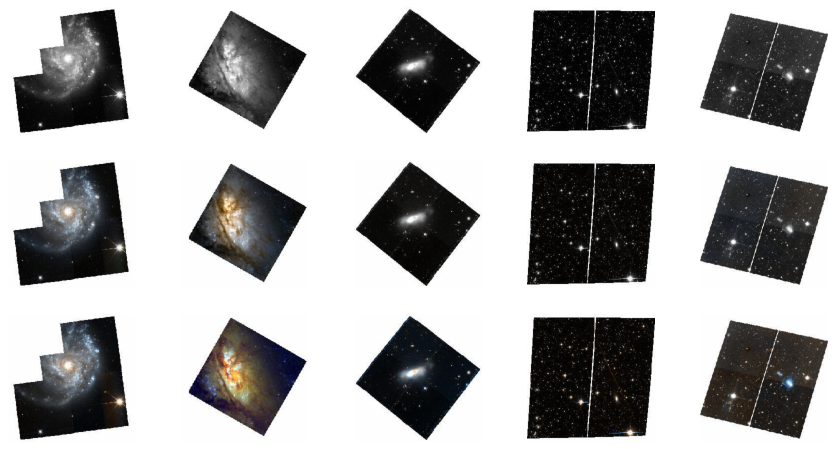


Epoch 11/20
Iteration 200/219
loss_D_fake: 0.67029
loss_D_real: 0.67262
loss_D: 0.67145
loss_G_GAN: 0.79996
loss_G_L1: 2.10927
loss_G: 2.90923


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


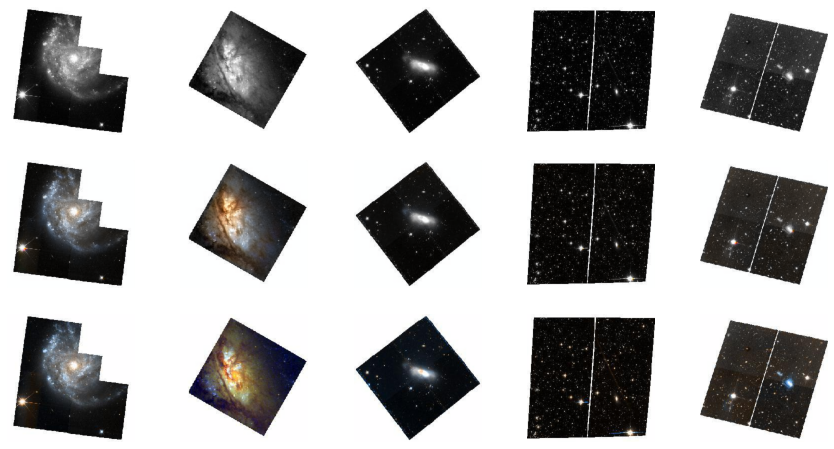


Epoch 12/20
Iteration 200/219
loss_D_fake: 0.66638
loss_D_real: 0.66903
loss_D: 0.66770
loss_G_GAN: 0.80343
loss_G_L1: 2.05965
loss_G: 2.86308


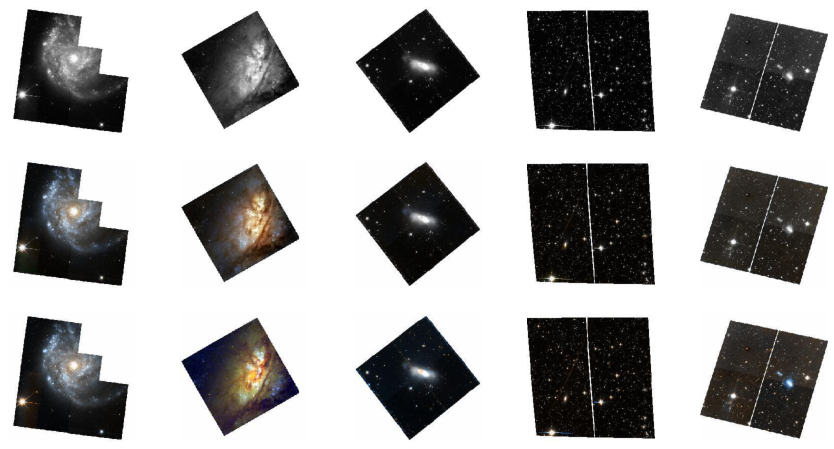


Epoch 13/20
Iteration 200/219
loss_D_fake: 0.66905
loss_D_real: 0.66907
loss_D: 0.66906
loss_G_GAN: 0.79715
loss_G_L1: 2.01510
loss_G: 2.81225


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 10 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


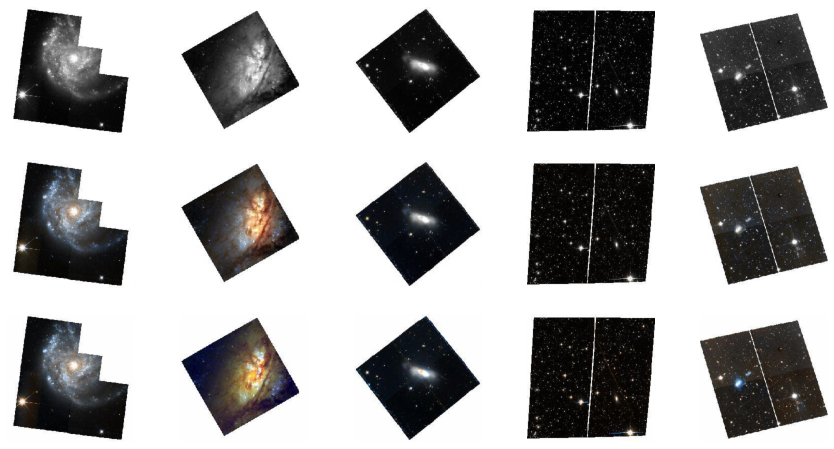


Epoch 14/20
Iteration 200/219
loss_D_fake: 0.66804
loss_D_real: 0.67126
loss_D: 0.66965
loss_G_GAN: 0.80246
loss_G_L1: 1.97212
loss_G: 2.77458


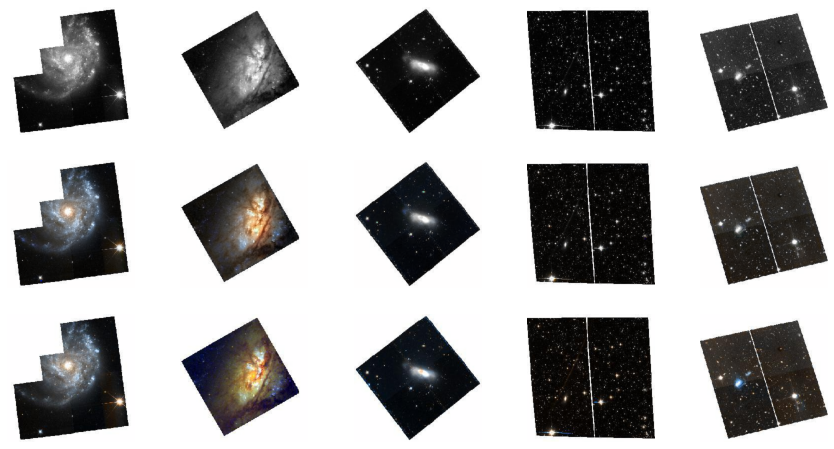


Epoch 15/20
Iteration 200/219
loss_D_fake: 0.66923
loss_D_real: 0.66733
loss_D: 0.66828
loss_G_GAN: 0.80512
loss_G_L1: 1.96586
loss_G: 2.77098


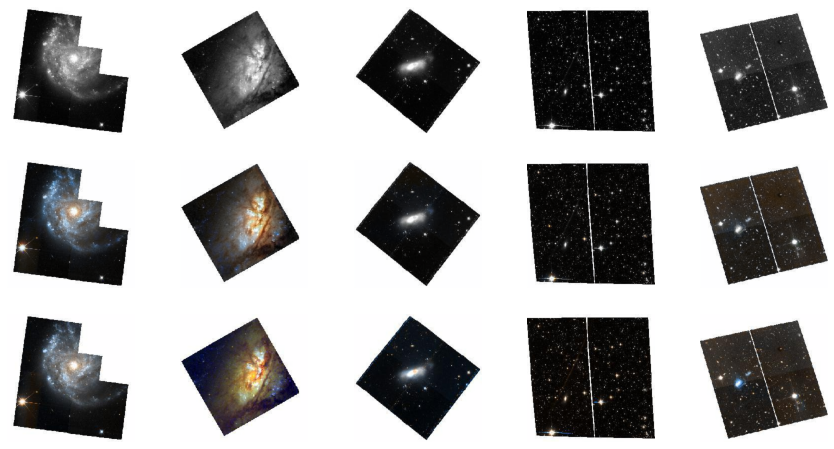


Epoch 16/20
Iteration 200/219
loss_D_fake: 0.67152
loss_D_real: 0.67435
loss_D: 0.67294
loss_G_GAN: 0.79090
loss_G_L1: 1.90927
loss_G: 2.70017


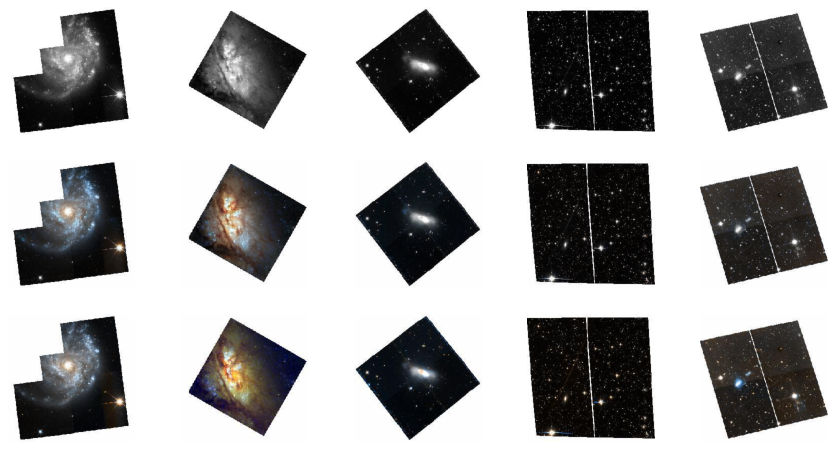


Epoch 17/20
Iteration 200/219
loss_D_fake: 0.67383
loss_D_real: 0.67302
loss_D: 0.67342
loss_G_GAN: 0.78258
loss_G_L1: 1.86404
loss_G: 2.64662


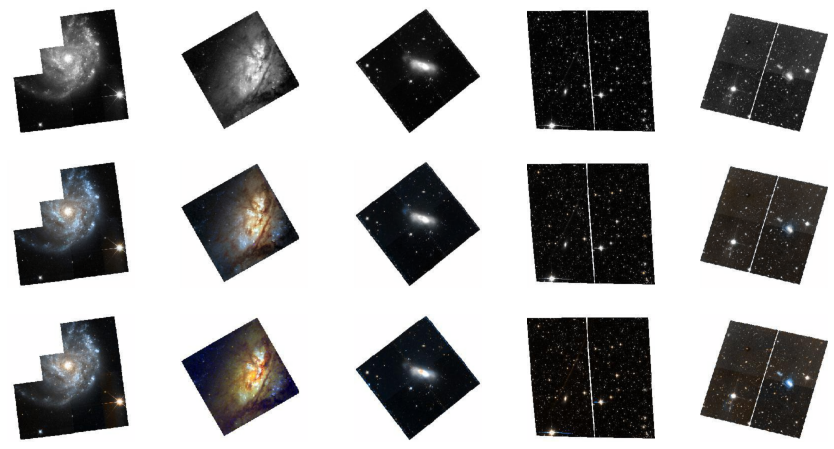


Epoch 18/20
Iteration 200/219
loss_D_fake: 0.67545
loss_D_real: 0.67580
loss_D: 0.67562
loss_G_GAN: 0.78026
loss_G_L1: 1.86849
loss_G: 2.64876


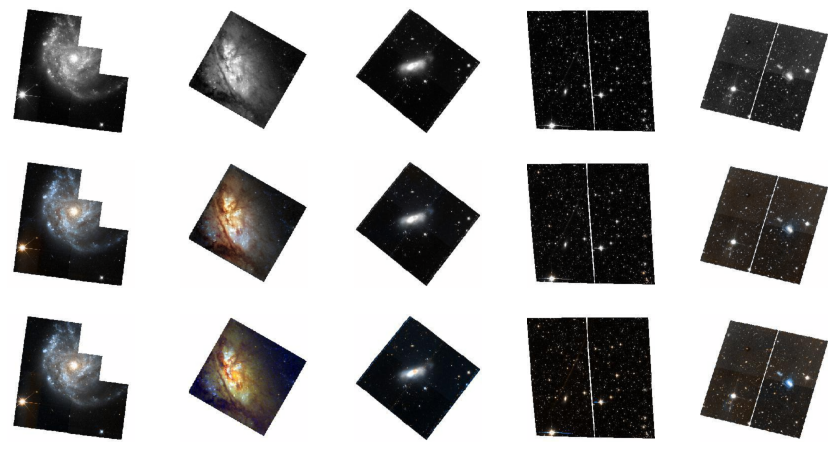


Epoch 19/20
Iteration 200/219
loss_D_fake: 0.67248
loss_D_real: 0.67682
loss_D: 0.67465
loss_G_GAN: 0.78775
loss_G_L1: 1.86705
loss_G: 2.65480


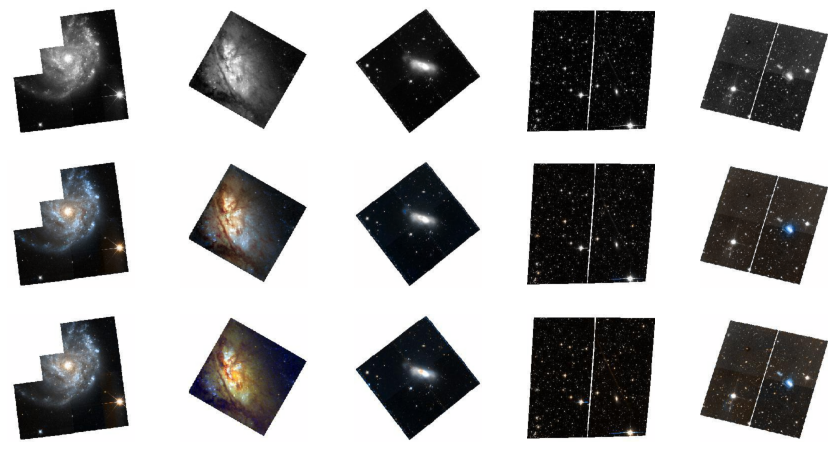


Epoch 20/20
Iteration 200/219
loss_D_fake: 0.67510
loss_D_real: 0.67519
loss_D: 0.67514
loss_G_GAN: 0.78315
loss_G_L1: 1.80432
loss_G: 2.58747


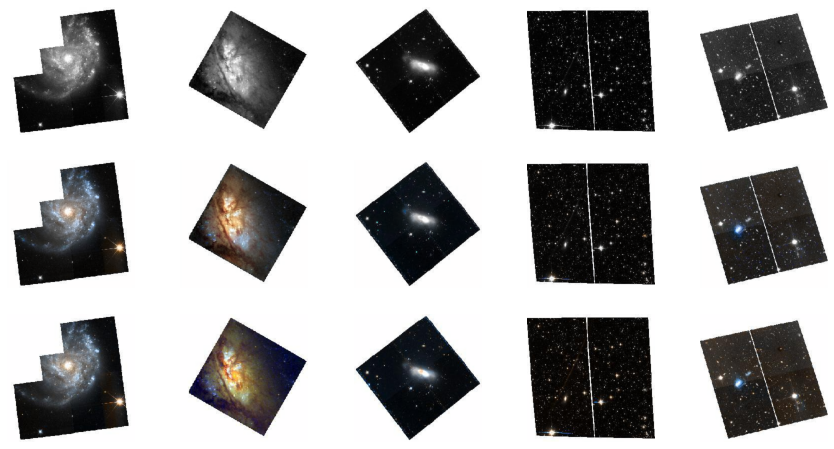

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("pytorch_resnet-18.pt", map_location=device))
model = MainModel(net_G=net_G)
train_model(model, train_dl, 20)

In [ ]:
torch.save(model.state_dict(),"full_trained.pt")

In [ ]:
!gdown --id 1lR6DcS4m5InSbZ5y59zkH2mHt_4RQ2KV

Downloading...
From: https://drive.google.com/uc?id=1lR6DcS4m5InSbZ5y59zkH2mHt_4RQ2KV
To: /content/final_model_weights.pt
136MB [00:01, 105MB/s] 


In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("pytorch_resnet-18.pt", map_location=device))
model = MainModel(net_G=net_G)
model.load_state_dict(torch.load("final_model_weights.pt", map_location=device))

model initialized with norm initialization


<All keys matched successfully>